In [1]:
#the module 'sys' allows istalling module from inside Jupyter
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
from sklearn.decomposition import LatentDirichletAllocation #package for LDA
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

#Natrual Language ToolKit (NLTK)
!{sys.executable} -m pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
%matplotlib inline

#ignore warnings about future changes in functions as they take too much space
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [50]:
#define text normalization function
%run ./Text_Normalization_Function_topic.ipynb #defining text normalization function

Processing c:\users\nsun9\appdata\local\pip\cache\wheels\4f\85\2a\67a30aa6cf144eca0c159f337ce5166df2213c4cde9e699cbe\html_parser-0.2-py3-none-any.whl


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsun9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nsun9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nsun9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nsun9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Below we define two functions that will display the results of fitting a topic model, to be used later:

In [46]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def get_topic_words(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_words = []
    for topic_weights in lda_model.components_:
        top_word_locs = (-topic_weights).argsort()[:n_words]
        topic_words.append(keywords.take(top_word_locs).tolist())
    return topic_words

In [47]:
listing= pd.read_csv('listings.csv')

# 1. Topic Modeling

## 1. Room Description Topic Modeling

### 1.1 Data loading and cleaning

In [48]:
room_df=listing[["id","description"]].copy()
room_df.fillna("NA",inplace=True)
room=room_df["description"]

In [51]:
normalized_room = normalize_corpus1(room)

In [53]:
#define a Bag-of-Words vecgtorizer
bow_vectorizer_room = CountVectorizer(max_features=500)

#vectorize data
bow_room= bow_vectorizer_room.fit_transform(normalized_room)

### 1.2 Use cross-validation to tune hyperparameters

Although it is intuitively weird to use cross validation for topic modeling, there are indeed some papers that prove it is reasonable.Cross-validation of topic modelling written by Peter Ellis：\
*Lacking such a heuristic to choose the number of topics, researchers have no recourse beyond an informed guess or time-consuming trial and error evaluation. For trial and error evaluation, an iterative approach is typical based on presenting different models with different numbers of topics, normally developed using cross-validation on held-out document sets, and selecting the number of topics for which the model is least perplexed by the test sets… Using the identified appropriate number of topics, LDA is performed on the whole dataset to obtain the topics for the corpus.*

In [31]:
## define the parameters grid used for cross-validation
search_params = {'n_components': [4,5,6,7], 'learning_decay': [0.5, 0.7, 0.9],\
                 "doc_topic_prior":[0.25,0.5,0.75,0.9],"topic_word_prior":[0.25,0.5,0.75,0.9]}

In [16]:
## Tune hyperparameters
##If scoring is None, the estimator’s score method is used. LDA's scoring method is log-likelihood as score
lda_room=LatentDirichletAllocation(random_state=42)
search_room = GridSearchCV(
    estimator=lda_room,
    param_grid=search_params,
    cv=3,
    n_jobs=-1 #using all processors
)
search_room.fit(bow_room)

GridSearchCV(cv=3, estimator=LatentDirichletAllocation(random_state=42),
             n_jobs=-1,
             param_grid={'doc_topic_prior': [0.25, 0.5, 0.75, 0.9],
                         'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7],
                         'topic_word_prior': [0.25, 0.5, 0.75, 0.9]})

In [18]:
search_room.best_params_

{'doc_topic_prior': 0.25,
 'learning_decay': 0.5,
 'n_components': 4,
 'topic_word_prior': 0.75}

### 1.3 Build the model with the best parameters

In [54]:
##Use the best model from CV
lda_room_best=LatentDirichletAllocation(n_components=4,learning_decay=0.5,doc_topic_prior=0.25,\
                      topic_word_prior=0.75,random_state=42).fit(bow_room)

In [33]:
##Display results with top 10 words for each topic:
no_top_words_room= 10
display_topics(lda_room_best, bow_vectorizer_room.get_feature_names(), no_top_words_room)

Topic 0:
kitchen fully clean night amenity living bathroom blueground furnish cdc
Topic 1:
building unit high include kitchen feature fully check common modern
Topic 2:
walk minute downtown line street station min park restaurant neighborhood
Topic 3:
kitchen bathroom private full living share queen size area large


In [172]:
word_weights_room= lda_room_best.components_ / lda_room_best.components_.sum(axis=1)[:, np.newaxis]
word_weights_room_df = pd.DataFrame(word_weights_room.T, 
                               index = bow_vectorizer_room.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(4)])
word_weights_room_df.sort_values(by='Topic_1',ascending=False).head(5)

,Topic_0,Topic_1,Topic_2,Topic_3
building,0.001744,0.018975,0.000628,0.004740
unit,0.009387,0.017541,0.002276,0.009694
high,0.007577,0.014959,0.000797,0.000159
include,0.006141,0.013192,0.002654,0.007053
kitchen,0.020479,0.013044,0.007250,0.031388


Visualize the topics for room description; we want rare and exclusive terms (i.e. found mostly in that topic) to rank on the top of the topic, so we choose a relatively **small lambda**

In [55]:
#prepare to display result in the Jupyter notebook
pyLDAvis.enable_notebook()

#run the visualization [mds is a function to use for visualizing the "distance" between topics]
pyLDAvis.sklearn.prepare(lda_room_best, bow_room,\
                         bow_vectorizer_room,mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  30.285852
3        1.782994 -295.079681       2        1  28.829608
1      220.811432 -343.832123       3        1  24.131173
0       50.533993  -76.050934       4        1  16.753368, topic_info=         Term         Freq        Total Category  logprob  loglift
477      walk  1964.000000  1964.000000  Default  30.0000  30.0000
287    minute  1292.000000  1292.000000  Default  29.0000  29.0000
34   bathroom  1713.000000  1713.000000  Default  28.0000  28.0000
285       min   716.000000   716.000000  Default  27.0000  27.0000
247      line   849.000000   849.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
486      well   206.603620   609.491618   Topic4  -4.7376   0.7047
143    entire   177.822769   353.407002   Topic4  -4.8877   1.0997
464      unit   221.403534  1307.827126   Topic4  -4.6685   0.0104
461        tv   201.403756   904.609319   Topic4  -4.7631   0.2844
217      high   178.718847   727.368686   Topic4  -4.8826   0.3830

[264 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
9         1  0.970340  adventurer
9         2  0.010323  adventurer
9         3  0.010323  adventurer
9         4  0.010323  adventurer
12        1  0.991458     airport
...     ...       ...         ...
497       4  0.008991        yard
499       1  0.004610       youre
499       2  0.064539       youre
499       3  0.004610       youre
499       4  0.926603       youre

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

### 1.4 Name topics and apply them to documents

According to the words in each topic, we name each of the topics as follow:\
Topic_0 4: Blueground furnished/clean & strictly follow COVID-19 prevention measures\
Topic_1 3: Provide great experience in deluxe rooms\
Topic_2 1:Convenient location &easy access to public transportation\
Topic_3 2: Fully equipped with abundant amenities

In [41]:
lda_room_topic_weights = lda_room_best.transform(bow_room)

In [166]:
#array of document "names" and topic "names" ("names" are just indecies)
doc_names = [room_df.id[i] for i in range(len(normalized_room))]
room_topic_names = ["Topic_" + str(i) for i in range(4)]

#convert to dataframe
df_room_topic = pd.DataFrame(np.round(lda_room_topic_weights, 4),\
                                    columns=room_topic_names, index=doc_names)
#vector of indecies for columns with the highest value by each row in df_description_topic
room_topic = np.argmax(df_room_topic.values, axis=1)

#add dominant_topic as a column to df_description_topic
df_room_topic['room_topic_num'] = room_topic
df_room_topic.head(5)

,Topic_0,Topic_1,Topic_2,Topic_3,room_topic_num
3781,0.0039,0.1239,0.4350,0.4372,3
6695,0.0042,0.1913,0.3652,0.4392,3
10813,0.0033,0.2870,0.2225,0.4872,3
10986,0.0046,0.4342,0.5565,0.0047,2
13247,0.0052,0.5704,0.4191,0.0053,1


In [167]:
df_room_topic.to_csv('room_topic.csv',index=False)

In [168]:
df_room_topic=df_room_topic["room_topic_num"].copy().reset_index()
df_room_topic.rename(columns={"index":"id"},inplace=True)
#df_room_topic.head(50)

## 2. Neighborhood overview topic modeling

### 2.1 Data loading and cleaning

In [56]:
neighborhood_df=listing[["id","neighborhood_overview"]].copy()
neighborhood_df.fillna("NA",inplace=True)
neighborhood=neighborhood_df["neighborhood_overview"]
neighborhood.head(3)

0    Mostly quiet ( no loud music, no crowed sidewa...
1    Peaceful, Architecturally interesting, histori...
2    Wander around this quintessential neighborhood...
Name: neighborhood_overview, dtype: object

In [57]:
normalized_neighborhood = normalize_corpus2(neighborhood)

In [58]:
#define a Bag-of-Words vecgtorizer
bow_vectorizer_neighborhood = CountVectorizer(max_features=500)

#vectorize data
bow_neighborhood= bow_vectorizer_neighborhood.fit_transform(normalized_neighborhood)

### 2.2 Use cross-validation to tune hyperparameters

#### 2.2.1 Small number of topics

In [28]:
## define the parameters grid used for cross-validation
search_params1 = {'n_components': [4,5,6,7], 'learning_decay': [0.5, 0.7, 0.9],\
                 "doc_topic_prior":[0.25,0.5,0.75,0.9],"topic_word_prior":[0.25,0.5,0.75,0.9]}

In [29]:
## Use cross-validation to tune hyperparameters
lda_neighborhood1 =LatentDirichletAllocation(random_state=42)
search_neighborhood1 = GridSearchCV(
    estimator=lda_neighborhood1,
    param_grid=search_params1,
    cv=3,
    n_jobs=-1 #using all processors
)
search_neighborhood1.fit(bow_neighborhood)

GridSearchCV(cv=3, estimator=LatentDirichletAllocation(random_state=42),
             n_jobs=-1,
             param_grid={'doc_topic_prior': [0.25, 0.5, 0.75, 0.9],
                         'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7],
                         'topic_word_prior': [0.25, 0.5, 0.75, 0.9]})

In [30]:
search_neighborhood1.best_params_

{'doc_topic_prior': 0.9,
 'learning_decay': 0.5,
 'n_components': 4,
 'topic_word_prior': 0.25}

Build the model with the best parameters

In [38]:
##Use the best model from CV
lda_neighborhood_best1=LatentDirichletAllocation(n_components=4,learning_decay=0.5,doc_topic_prior=0.9,\
                      topic_word_prior=0.25,random_state=42).fit(bow_neighborhood)

#### 2.2.2 Large number of topics

In [28]:
## define the parameters grid used for cross-validation
search_params2 = {'n_components': [8,10,12,14], 'learning_decay': [0.5, 0.7, 0.9],\
                 "doc_topic_prior":[0.25,0.5,0.75,0.9],"topic_word_prior":[0.25,0.5,0.75,0.9]}

In [ ]:
## Use cross-validation to tune hyperparameters
lda_neighborhood2 =LatentDirichletAllocation(random_state=42)
search_neighborhood2 = GridSearchCV(
    estimator=lda_neighborhood2,
    param_grid=search_params2,
    cv=3,
    n_jobs=-1 #using all processors
)
search_neighborhood2.fit(bow_neighborhood)

In [ ]:
search_neighborhood2.best_params_

Build the model with the best parameters

In [59]:
##Use the best model from CV
lda_neighborhood_best2=LatentDirichletAllocation(n_components=8,learning_decay=0.5,doc_topic_prior=0.9,\
                      topic_word_prior=0.25,random_state=42).fit(bow_neighborhood)

#### 2.2.3 Compare the three "best models"

We use Log-Likelihood Score to compare the three level of topics: use the .score attribute of our defined and fitted LDA function:

In [54]:
print("Log-Likelihood (higher values are better) for best model 1 is :{}\nLog-Likelihood (higher values are better) for best model 2 is :{}".format(lda_neighborhood_best1.score(bow_neighborhood),lda_neighborhood_best2.score(bow_neighborhood),))

Log-Likelihood (higher values are better) for best model 1 is :-287793.70810230554
Log-Likelihood (higher values are better) for best model 2 is :-284749.4009353971


Based on the Log-Likelihood score and human judgment, we choose the model with 8 topics

### 2.3 Name topics and apply them to documents

In [55]:
no_top_words_neighborhood=10
display_topics(lda_neighborhood_best2, bow_vectorizer_neighborhood.get_feature_names(), no_top_words_neighborhood)

Topic 0:
bay beacon public newbury south historic shopping copley square shop
Topic 1:
park diverse river restaurant dorchester professional large library include public
Topic 2:
hill park jamaica shop plain pond restaurant bus local arboretum
Topic 3:
downtown station subway beach south park line building traffic quiet
Topic 4:
college north trail freedom hall tuft museum public ride marathon
Topic 5:
restaurant best bar place safe old east friendly enjoy beautiful
Topic 6:
station north garden furnished major use public train transportation entertainment
Topic 7:
restaurant line medical center harvard store fenway drive university hospital


In [63]:
#prepare to display result in the Jupyter notebook

pyLDAvis.sklearn.prepare(lda_neighborhood_best2, bow_neighborhood,\
                        bow_vectorizer_neighborhood,mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  15.610096
0      186.487061  -98.103249       2        1  13.790001
4       19.245832  160.858780       3        1  13.030372
2      170.658829   75.445076       4        1  12.768535
3       -1.386411  -35.043739       5        1  12.178206
7     -145.800095  106.944611       6        1  12.022931
1       64.834541 -221.825272       7        1  11.801836
6     -196.906036  -58.990913       8        1   8.798023, topic_info=           Term         Freq        Total Category  logprob  loglift
414     station   609.000000   609.000000  Default  30.0000  30.0000
312       north   509.000000   509.000000  Default  29.0000  29.0000
96      college   406.000000   406.000000  Default  28.0000  28.0000
369  restaurant  1072.000000  1072.000000  Default  27.0000  27.0000
144    downtown   644.000000   644.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
452       train   108.424887   245.622721   Topic8  -3.7181   1.6129
265        live    87.634501   202.673441   Topic8  -3.9310   1.5922
358      public   108.429563   608.429352   Topic8  -3.7181   0.7059
55       border    56.202486   114.172009   Topic8  -4.3752   1.7219
68     building    67.131906   261.920401   Topic8  -4.1975   1.0693

[418 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.951351    1800s
4         1  0.105677     adam
4         4  0.866553     adam
5         2  0.960902      add
7         1  0.078406  african
...     ...       ...      ...
498       4  0.079335    young
498       7  0.370231    young
498       8  0.089913    young
499       4  0.086896      zoo
499       7  0.883439      zoo

[915 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 3, 4, 8, 2, 7])

According to the words in each topic, we name each of the topics as follow:\
Topic_0 2: Downtown, finest, high-end lifestyle, historic charm\
Topic_1 7: Racially &culturally& economically diverse, peaceful, quiet and safe\
Topic_2 4: Racially &culturally& economically diverse, close to parks and ponds\
Topic_3 5: Close to beach and downtown, busy, culturally rich\
Topic_4 3: Close to famous colleges/universities and tourist destinations, the heart of Boston\
Topic_5 1: Quiet,safe, residential,local restaurant\
Topic_6 8: Entertainment, relaxing, new, convenient transportation\
Topic_7 6: Proximity to hospitals and universities, with many restaurants

In [169]:
lda_neighborhood_topic_weights = lda_neighborhood_best2.transform(bow_neighborhood)
#array of document "names" and topic "names" ("names" are just indecies)
doc_names = [neighborhood_df.id[i] for i in range(len(normalized_neighborhood))]
neighborhood_topic_names = ["Topic_" + str(i) for i in range(8)]

#convert to dataframe
df_neighborhood_topic = pd.DataFrame(np.round(lda_neighborhood_topic_weights, 8),\
                                    columns=neighborhood_topic_names, index=doc_names)
#vector of indecies for columns with the highest value by each row in df_description_topic
neighborhood_topic = np.argmax(df_neighborhood_topic.values, axis=1)

#add dominant_topic as a column to df_description_topic
df_neighborhood_topic['neighborhood_topic_num'] = neighborhood_topic
df_neighborhood_topic.head(5)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,neighborhood_topic_num
3781,0.055917,0.071436,0.052309,0.083740,0.039143,0.490490,0.157355,0.049611,5
6695,0.093721,0.299647,0.159383,0.075618,0.068954,0.169683,0.063602,0.069393,1
10813,0.316495,0.255372,0.074943,0.019567,0.073606,0.218479,0.015479,0.026057,0
10986,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0
13247,0.230558,0.105078,0.129213,0.091173,0.089481,0.129195,0.091819,0.133484,0


In [170]:
df_neighborhood_topic.to_csv('neighborhood_topic.csv',index=False)

In [171]:
df_neighborhood_topic=df_neighborhood_topic["neighborhood_topic_num"].copy().reset_index()
df_neighborhood_topic.rename(columns={"index":"id"},inplace=True)
#df_neighborhood_topic.head(20)

In [129]:
listing_new=listing[["id",'listing_url',"name","neighbourhood_cleansed","latitude","longitude","property_type",\
                     "room_type","accommodates","bathrooms_text",'bedrooms', 'beds',\
                     "price",'number_of_reviews','number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',\
                    'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
                    'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value',\
                     'description','neighborhood_overview']]

In [130]:
listing_new=listing_new.merge(df_room_topic,how="inner",on="id")
listing_new=listing_new.merge(df_neighborhood_topic,how="inner",on="id")
#listing_new.head(5)

In [145]:
def clean_neighborhood_topic(listing):
    if pd.isnull(listing["neighborhood_overview"]):
        return "-"
    else: 
        return listing["neighborhood_topic_num"]
def clean_room_topic(listing):
    if pd.isnull(listing["description"]):
        return "-"
    else:
        return listing["room_topic_num"]

In [146]:
listing_new["neighborhood_topic_num"]=listing_new.apply(clean_neighborhood_topic,axis=1)
listing_new["room_topic_num"]=listing_new.apply(clean_room_topic,axis=1)

## 3. Host overview topic modeling

### 3.1 Data loading and cleaning

In [173]:
host_df=listing[["id","host_about"]].copy()
host_df.fillna("NA",inplace=True)
host=host_df["host_about"]
host.head(3)

0    My wife and I and grown children frequently oc...
1                Relaxed,  Easy going, Accommodating. 
2                                                   NA
Name: host_about, dtype: object

In [174]:
normalized_host = normalize_corpus3(host)
bow_vectorizer_host = CountVectorizer(max_features=500)
bow_host= bow_vectorizer_host.fit_transform(normalized_host)

### 3.2 Use cross-validation to tune hyperparameters

In [61]:
## define the parameters grid used for cross-validation
search_params_host = {'n_components': [4,5,6,7,8], 'learning_decay': [0.5, 0.7, 0.9],\
                 "doc_topic_prior":[0.25,0.5,0.75,0.9],"topic_word_prior":[0.25,0.5,0.75,0.9]}

In [62]:
lda_host =LatentDirichletAllocation(random_state=42)
search_host = GridSearchCV(
    estimator=lda_host,
    param_grid=search_params_host,
    cv=3,
    n_jobs=-1 #using all processors
)
search_host.fit(bow_host)

GridSearchCV(cv=3, estimator=LatentDirichletAllocation(random_state=42),
             n_jobs=-1,
             param_grid={'doc_topic_prior': [0.25, 0.5, 0.75, 0.9],
                         'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7, 8],
                         'topic_word_prior': [0.25, 0.5, 0.75, 0.9]})

In [63]:
search_host.best_params_

{'doc_topic_prior': 0.25,
 'learning_decay': 0.5,
 'n_components': 8,
 'topic_word_prior': 0.25}

### 3.3 Build the model with the best parameters

In [175]:
lda_host_best=LatentDirichletAllocation(n_components=8,learning_decay=0.5,doc_topic_prior=0.25,\
                      topic_word_prior=0.25,random_state=42).fit(bow_host)

Unfortunately, we did not find obvious topics for the host description. The topic words and rare & exclusive terms in each host description topic are not coherent enough to label them. It is possible that the host description doesn’t share common topics, so the machine cannot dig out topics. 

In [176]:
##Display results with top 10 words for each topic:
no_top_words_host = 5
display_topics(lda_host_best, bow_vectorizer_host.get_feature_names(), no_top_words_host)

Topic 0:
rental manage inquire website hide
Topic 1:
suite team question lance brownstone
Topic 2:
cleaning low area use life
Topic 3:
hospital amazing free world family
Topic 4:
enjoy team blueground quality experience
Topic 5:
love travel live enjoy new
Topic 6:
medical work property hospital team
Topic 7:
furnish month hour term fi


In [177]:
pyLDAvis.sklearn.prepare(lda_host_best, bow_host,\
                        bow_vectorizer_host,mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4     -108.958252 -208.941483       1        1  27.946358
5      186.487061  -98.103249       2        1  24.241110
7       19.245832  160.858780       3        1  13.501536
1      170.658829   75.445076       4        1  10.193943
6       -1.386411  -35.043739       5        1   6.557238
3     -145.800095  106.944611       6        1   6.534572
2       64.834541 -221.825272       7        1   5.948066
0     -196.906036  -58.990913       8        1   5.077178, topic_info=         Term         Freq        Total Category  logprob  loglift
378    rental   450.000000   450.000000  Default  30.0000  30.0000
261      love  1183.000000  1183.000000  Default  29.0000  29.0000
73   cleaning   432.000000   432.000000  Default  28.0000  28.0000
206  hospital   276.000000   276.000000  Default  27.0000  27.0000
441      term   442.000000   442.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
106  customer     9.624391    54.892198   Topic8  -5.8447   1.2393
255  location    30.079883   202.585797   Topic8  -4.7052   1.0731
358  property    18.466992   189.985532   Topic8  -5.1930   0.6495
279      meet    20.124663   263.834760   Topic8  -5.1071   0.4070
175      give    19.307285   244.745665   Topic8  -5.1485   0.4407

[419 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         2  0.144799  accommodate
1         4  0.547017  accommodate
1         6  0.112621  accommodate
1         7  0.185020  accommodate
2         1  0.991715   additional
...     ...       ...          ...
496       5  0.060335        world
496       6  0.200399        world
496       7  0.002155        world
497       4  0.974081        yanli
499       2  0.975232        young

[745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 8, 2, 7, 4, 3, 1])

## 4. Reviews topic modeling

### 4.1 Data loading and cleaning

In [64]:
from langdetect import detect
review_df= pd.read_csv('reviews.csv')

A small percentage of the data is in foreign languages,we removed comments in foreign languages

In [65]:
def detect_language(review):
    try :
        language=detect(review)
    except:
        language="others"
    return language

In [67]:
review_df["language"]=review_df["comments"].apply(detect_language)
review_df=review_df[review_df["language"]=="en"]
review=review_df["comments"]

In [68]:
normalized_review = normalize_corpus4(review)
bow_vectorizer_review = CountVectorizer(max_features=500)
bow_review= bow_vectorizer_review.fit_transform(normalized_review)

We tried to use cross-validation to find the best parameters. However, the data value is too large that cross-validation will take das to find the optimal solution. So we just tried three models with different topics and used to compare the result. 

In [ ]:
## define the parameters grid used for cross-validation
search_params_review = {'n_components': [5,6,7,8,9,10], 'learning_decay': [0.5, 0.7, 0.9],\
                 "doc_topic_prior":[0.25,0.5,0.75,0.9],"topic_word_prior":[0.25,0.5,0.75,0.9]}

In [ ]:
lda_review =LatentDirichletAllocation(random_state=42)
search_review = GridSearchCV(
    estimator=lda_review,
    param_grid=search_params_review,
    cv=3,
    n_jobs=-1 #using all processors
)
search_review.fit(bow_review)

In [ ]:
search_review.best_params_

### 4.2 Build the model with the best parameters

In [164]:
lda_review_1=LatentDirichletAllocation(n_components=10,learning_decay=0.5,doc_topic_prior=0.5,\
                      topic_word_prior=0.5,random_state=42).fit(bow_review)

In [69]:
lda_review_2=LatentDirichletAllocation(n_components=8,learning_decay=0.5,doc_topic_prior=0.5,\
                      topic_word_prior=0.5,random_state=42).fit(bow_review)

In [162]:
lda_review_3=LatentDirichletAllocation(n_components=12,learning_decay=0.5,doc_topic_prior=0.5,\
                      topic_word_prior=0.5,random_state=42).fit(bow_review)

In [165]:
lda_review_1.score(bow_review),lda_review_2.score(bow_review),lda_review_3.score(bow_review),

(-7517111.76173793, -7506563.719400498, -7537192.374942007)

### 4.3 Name topics and apply them to documents

In [159]:
no_top_words_review=10
display_topics(lda_review_2, bow_vectorizer_review.get_feature_names(), no_top_words_review)

Topic 0:
love bed kitchen bathroom lovely coffee breakfast bedroom comfortable comfy
Topic 1:
walk restaurant easy minute distance quiet downtown street area within
Topic 2:
day night guest parking take arrive host door time check
Topic 3:
area best unit bed night sleep comfortable hotel much people
Topic 4:
nice close airport host near studio good center right public
Topic 5:
clean location good check comfortable easy perfect communication excellent beautiful
Topic 6:
quick locate convenient question respond clean cozy wonderful comfortable always
Topic 7:
great location host amazing helpful responsive spot perfect clean fantastic


In [160]:
word_weights_review= lda_review_2.components_ / lda_review_2.components_.sum(axis=1)[:, np.newaxis]
word_weights_review_df = pd.DataFrame(word_weights_review.T, 
                               index = bow_vectorizer_review.get_feature_names(), 
                               columns = ["Topic_" + str(i) for i in range(8)])
#word_weights_review_df.sort_values(by='Topic_0',ascending=False).head(10)

In [70]:
pyLDAvis.enable_notebook()

#run the visualization [mds is a function to use for visualizing the "distance" between topics]
pyLDAvis.sklearn.prepare(lda_review_2, bow_review,\
                         bow_vectorizer_review,mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -108.958252 -208.941483       1        1  18.984900
1      186.487061  -98.103249       2        1  15.641819
0       19.245832  160.858780       3        1  13.019546
7      170.658829   75.445076       4        1  11.695744
3       -1.386411  -35.043739       5        1  11.118325
5     -145.800095  106.944611       6        1  10.927566
6       64.834541 -221.825272       7        1   9.741357
4     -196.906036  -58.990913       8        1   8.870742, topic_info=         Term          Freq         Total Category  logprob  loglift
199     great  58539.000000  58539.000000  Default  30.0000  30.0000
304      nice  23941.000000  23941.000000  Default  29.0000  29.0000
266  location  35978.000000  35978.000000  Default  28.0000  28.0000
91      close  15776.000000  15776.000000  Default  27.0000  27.0000
89      clean  36290.000000  36290.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
222      host   3396.344551  27027.002813   Topic8  -3.5402   0.3483
56        big    989.341698   3192.485812   Topic8  -4.7736   1.2509
266  location   1721.246773  35978.350593   Topic8  -4.2199  -0.6175
418   station   1018.255497   6221.550784   Topic8  -4.7448   0.6125
89      clean   1418.025541  36290.814783   Topic8  -4.4136  -0.8199

[415 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.004314  absolutely
1         2  0.007704  absolutely
1         3  0.034513  absolutely
1         4  0.030199  absolutely
1         5  0.905041  absolutely
...     ...       ...         ...
499       4  0.019041       youre
499       5  0.680945       youre
499       6  0.001813       youre
499       7  0.015414       youre
499       8  0.031735       youre

[2533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 8, 4, 6, 7, 5])

According to the words in each topic, we name each of the topics as follow:\
Topic_0 4: kitchen, food, bed\
Topic_1 1: nearby restaurant, quiet environment\
Topic_2 2: check-in&out,parking\
Topic_3 3: quiet environment\
Topic_4 8: airport,transportation\
Topic_5 6: cleaness, communication with host\
Topic_6 7: quick response from host\
Topic_7 5: helpful and responsive host, amenities

In [211]:
lda_review_topic_weights = lda_review_2.transform(bow_review)
#array of document "names" and topic "names" ("names" are just indecies)
doc_names = reviews_df.id
review_topic_names = ["Topic_" + str(i) for i in range(8)]

#convert to dataframe
df_review_topic = pd.DataFrame(np.round(lda_review_topic_weights, 8),\
                                    columns=review_topic_names, index=doc_names)
#vector of indecies for columns with the highest value by each row
review_topic = np.argmax(df_review_topic.values, axis=1)

#add dominant_topic as a column to df_description_topic
df_review_topic['review_topic'] = review_topic
df_review_topic.head(5)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,review_topic
id,,,,,,,,,
37776825,0.059541,0.056998,0.071553,0.169441,0.057931,0.381253,0.076461,0.126821,5
41842494,0.041105,0.616742,0.032224,0.053054,0.101484,0.061177,0.040056,0.054158,1
45282151,0.042181,0.051322,0.154868,0.299625,0.169130,0.064678,0.143070,0.075126,3
49022647,0.229794,0.031625,0.159674,0.038798,0.027350,0.161497,0.036119,0.315143,7
52503327,0.013918,0.339400,0.130065,0.048543,0.238670,0.070627,0.032722,0.126055,1


In [213]:
review_2nd_topic_df=pd.DataFrame(np.array(df_review_topic).argsort()[:,-3],columns = ['review_2nd_topic'])
review_2nd_topic_df.head()

,review_2nd_topic
0,3
1,4
2,4
3,0
4,4


In [214]:
review_3rd_topic_df=pd.DataFrame(np.array(df_review_topic).argsort()[:,-4],columns = ['review_3rd_topic'])
review_3rd_topic_df.head()

,review_3rd_topic
0,7
1,5
2,2
3,5
4,2


In [215]:
df_review_topic.reset_index(inplace=True)
df_review_topic.head(5)

,id,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,review_topic
0,37776825,0.059541,0.056998,0.071553,0.169441,0.057931,0.381253,0.076461,0.126821,5
1,41842494,0.041105,0.616742,0.032224,0.053054,0.101484,0.061177,0.040056,0.054158,1
2,45282151,0.042181,0.051322,0.154868,0.299625,0.169130,0.064678,0.143070,0.075126,3
3,49022647,0.229794,0.031625,0.159674,0.038798,0.027350,0.161497,0.036119,0.315143,7
4,52503327,0.013918,0.339400,0.130065,0.048543,0.238670,0.070627,0.032722,0.126055,1


In [206]:
df_review_topic.to_csv('review_topic.csv',index=False)

In [216]:
df_review_topics=pd.concat([df_review_topic,review_2nd_topic_df],axis=1)
df_review_topics=pd.concat([df_review_topics,review_3rd_topic_df],axis=1)
df_review_topics=df_review_topics[["id","review_topic","review_2nd_topic","review_3rd_topic"]]
df_review_topics.head(5)

,id,review_topic,review_2nd_topic,review_3rd_topic
0,37776825,5,3,7
1,41842494,1,4,5
2,45282151,3,4,2
3,49022647,7,0,5
4,52503327,1,4,2


# 2. Sentiment Analysis

In [3]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nsun9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
def analyze_sentiment_vader(review):
    scores = analyzer.polarity_scores(review)  

    return scores['compound']

def main():
	df = pd.read_csv("reviews.csv")

	reviews = np.array(df["comments"])
	scores = []
	drop_index_list = []

	for review in reviews:
		try:
			score = analyze_sentiment_vader(review)
			scores.append("-" if score == 0 and detect(review) != "en" else score)
		except:
			scores.append("-")
			pass
	print("review score done")


	df["sentiment_scores"] = scores
	df = df[df["sentiment_scores"]!="-"]

    
	return df

In [27]:
review_new=main()
review_new.head()

review score done


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment_scores
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...,0.807
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...,0.5719
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...,0.9557
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...,0.978
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...,0.5578


In [28]:
review_new["sentiment_scores"]=review_new["sentiment_scores"].astype("float64")

Calculate the mean and standard deviation to get a general idea

In [29]:
review_new["sentiment_scores"].mean(),review_new["sentiment_scores"].std()

(0.8141962465205614, 0.267160811033852)

Plot the histogram to explore the distribution of the sentiment scores

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B5E9C07E20>],
      dtype=object)

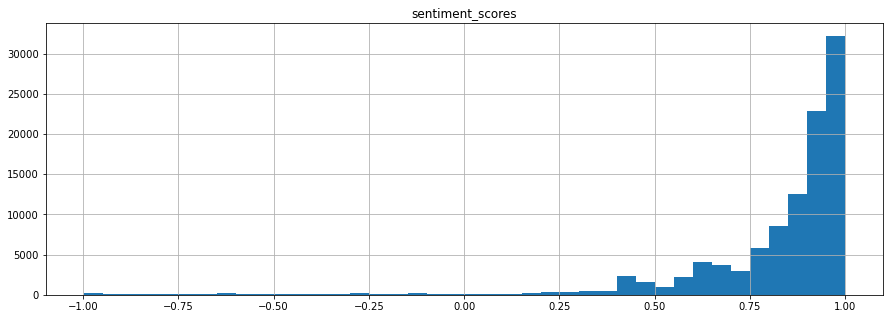

In [11]:
fig1 , ax1 = plt.subplots(nrows=1,ncols=1, figsize = (15,5))
review_new.hist(column='sentiment_scores',bins=40,ax=ax1)

Most of the compounding scores are above 0.5. In order to compare the results, we set 5 levels, from “A” to “E”, based on the distribution of all the scores. Those five buckets can help us compare the relative preference customers have on all the listings. 

In [13]:
def assign_review_grade(score,score_mean,score_std):
    if score>0.95:
        return "A"
    elif score>0.9:
        return "B"
    elif score>0.6:
        return "C"
    elif score>0.3:
        return "D"
    else:
        return "E"

In [14]:
review_new["sentiment_grades"]=review_new["sentiment_scores"].apply(assign_review_grade,score_mean=review_new["sentiment_scores"].mean(),\
                                                      score_std=review_new["sentiment_scores"].std())
review_new["sentiment_grades"].value_counts(normalize=True)

C    0.365008
A    0.305147
B    0.217738
D    0.075959
E    0.036148
Name: sentiment_grades, dtype: float64

In [30]:
review_new=review_new.merge(df_review_topics,how="left",on="id")
review_new.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment_scores,review_topic,review_2nd_topic,review_3rd_topic
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...,0.8070,5.0,3.0,7.0
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...,0.5719,1.0,4.0,5.0
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...,0.9557,3.0,4.0,2.0
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...,0.9780,7.0,0.0,5.0
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...,0.5578,1.0,4.0,2.0


In [31]:
review_new.to_csv('review_new.csv',index=False)

Calculate the average sentiment score for each room and assign a grade to each room

In [32]:
listing_review=review_new.groupby(by="listing_id")["sentiment_scores"].mean().reset_index()
listing_review["sentiment_grades"]=listing_review["sentiment_scores"].apply(assign_review_grade,score_mean=review_new["sentiment_scores"].mean(),\
                                                      score_std=review_new["sentiment_scores"].std())
listing_review.head(5)

,listing_id,sentiment_scores,sentiment_grades
0,3781,0.878200,C
1,6695,0.861630,C
2,10813,0.798575,C
3,18711,0.725827,C
4,22195,0.641442,C


In [34]:
listing_review["sentiment_grades"].value_counts(normalize=True)

C    0.770396
B    0.111383
A    0.050318
D    0.049340
E    0.018564
Name: sentiment_grades, dtype: float64

In [72]:
listing_new=listing_new.merge(listing_review,how="left",left_on="id",right_on="listing_id")
listing_new.drop(["listing_id"],axis=1,inplace=True)

Categorized numeric ratings into five levels and gave each numeric rating a grade based on the distribution of the five grades in text reviews. 

In [41]:
def assign_num_reviw_grades(score,e,d,c,b):
    if score<e:
        return "E"
    elif score<d:
        return "D"
    elif score<c:
        return "C"
    elif score<b:
        return "B"
    elif pd.isnull(score):
        return "-"
    else:
        return "A"

In [43]:
listing_new["num_rating_grades"]=listing_new.review_scores_rating.apply(assign_num_reviw_grades,e=listing_new.review_scores_rating.quantile(0.018564),\
                                                                  d=listing_new.review_scores_rating.quantile(0.067904),\
                                                                 c=listing_new.review_scores_rating.quantile(0.8382999999999999),\
                                                                 b=listing_new.review_scores_rating.quantile(0.9496829999999999))

In [44]:
listing_new["num_rating_grades"].value_counts(normalize=True)

C    0.511997
-    0.304157
A    0.159175
D    0.017911
E    0.006759
Name: num_rating_grades, dtype: float64

In [76]:
listing_new.head(5)

,id,listing_url,name,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,...,review_scores_communication,review_scores_location,review_scores_value,description,neighborhood_overview,room_topic_num,neighborhood_topic_num,num_rating_grades,sentiment_scores,sentiment_grades
0,3781,https://www.airbnb.com/rooms/3781,HARBORSIDE-Walk to subway,East Boston,42.36413,-71.02991,Entire apartment,Entire home/apt,2,1 bath,...,10.0,10.0,10.0,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",3,5,C,0.878200,C
1,6695,https://www.airbnb.com/rooms/6695,$99 Special!! Home Away! Condo,Roxbury,42.32994,-71.09351,Entire condominium,Entire home/apt,4,1 bath,...,10.0,9.0,10.0,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",3,1,C,0.861630,C
2,10813,https://www.airbnb.com/rooms/10813,"Back Bay Apt-blocks to subway, Newbury St, The...",Back Bay,42.35061,-71.08787,Entire apartment,Entire home/apt,3,1 bath,...,10.0,10.0,10.0,Stunning Back Bay furnished studio apartment. ...,Wander around this quintessential neighborhood...,3,0,C,0.798575,C
3,10986,https://www.airbnb.com/rooms/10986,North End (Waterfront area) CLOSE TO MGH & SU...,North End,42.36352,-71.05075,Entire condominium,Entire home/apt,2,1 bath,...,NaN,NaN,NaN,Chic furnished studio apartment is located on ...,NaN,2,-,-,NaN,NaN
4,13247,https://www.airbnb.com/rooms/13247,Back Bay studio apartment,Back Bay,42.35164,-71.08752,Entire home/apt,Entire home/apt,1,1 bath,...,NaN,NaN,NaN,Beautiful studio apartment in a great Back Bay...,The Back Bay has so many great shops & restaur...,1,0,-,NaN,NaN


In [77]:
listing_new.to_csv('listing_new.csv',index=False)